In [97]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import torch
import copy
import torch.nn as nn
import torch.autograd as autograd
import torch.optim as optim
import torch.utils.data
from torch.nn import functional as F
import math
from torch.nn.parameter import Parameter
from torch.nn.functional import pad
from torch.nn.modules import Module
from torch.nn.modules.utils import _single, _pair, _triple
import numpy as np
import matplotlib.pyplot as plt
import os
from torch.autograd import Variable
import sys
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
import scipy.io as sio
import pdb
%matplotlib inline

#Wireless Parameters
N_t = 64
N_r = 16
latent_dim = 65

if torch.cuda.is_available():
    dtype = torch.cuda.FloatTensor
    dtype_long = torch.cuda.LongTensor
else:
    dtype = torch.FloatTensor
    dtype_long = torch.LongTensor

class _ConvNd(Module):

    def __init__(self, in_channels, out_channels, kernel_size, stride,
                 padding, dilation, transposed, output_padding, groups, bias):
        super(_ConvNd, self).__init__()
        if in_channels % groups != 0:
            raise ValueError('in_channels must be divisible by groups')
        if out_channels % groups != 0:
            raise ValueError('out_channels must be divisible by groups')
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.dilation = dilation
        self.transposed = transposed
        self.output_padding = output_padding
        self.groups = groups
        if transposed:
            self.weight = Parameter(torch.Tensor(
                in_channels, out_channels // groups, *kernel_size))
        else:
            self.weight = Parameter(torch.Tensor(
                out_channels, in_channels // groups, *kernel_size))
        if bias:
            self.bias = Parameter(torch.Tensor(out_channels))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        n = self.in_channels
        for k in self.kernel_size:
            n *= k
        stdv = 1. / math.sqrt(n)
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def __repr__(self):
        s = ('{name}({in_channels}, {out_channels}, kernel_size={kernel_size}'
             ', stride={stride}')
        if self.padding != (0,) * len(self.padding):
            s += ', padding={padding}'
        if self.dilation != (1,) * len(self.dilation):
            s += ', dilation={dilation}'
        if self.output_padding != (0,) * len(self.output_padding):
            s += ', output_padding={output_padding}'
        if self.groups != 1:
            s += ', groups={groups}'
        if self.bias is None:
            s += ', bias=False'
        s += ')'
        return s.format(name=self.__class__.__name__, **self.__dict__)


class Conv2d(_ConvNd):

    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
                 padding=0, dilation=1, groups=1, bias=True):
        kernel_size = _pair(kernel_size)
        stride = _pair(stride)
        padding = _pair(padding)
        dilation = _pair(dilation)
        super(Conv2d, self).__init__(
            in_channels, out_channels, kernel_size, stride, padding, dilation,
            False, _pair(0), groups, bias)

    def forward(self, input):
        return conv2d_same_padding(input, self.weight, self.bias, self.stride,
                        self.padding, self.dilation, self.groups)


# custom con2d, because pytorch don't have "padding='same'" option.
def conv2d_same_padding(input, weight, bias=None, stride=1, padding=1, dilation=1, groups=1):

    input_rows = input.size(2)
    filter_rows = weight.size(2)
    effective_filter_size_rows = (filter_rows - 1) * dilation[0] + 1
    out_rows = (input_rows + stride[0] - 1) // stride[0]
    padding_needed = max(0, (out_rows - 1) * stride[0] + effective_filter_size_rows - input_rows)
    padding_rows = max(0, (out_rows - 1) * stride[0] + (filter_rows - 1) * dilation[0] + 1 - input_rows)
    rows_odd = (padding_rows % 2 != 0)
    # same for padding_cols
    input_cols = input.size(3)
    filter_cols = weight.size(3)
    effective_filter_size_cols = (filter_cols - 1) * dilation[0] + 1
    out_cols = (input_cols + stride[0] - 1) // stride[0]
    padding_needed = max(0, (out_cols - 1) * stride[0] + effective_filter_size_cols - input_cols)
    padding_cols = max(0, (out_cols - 1) * stride[0] + (filter_cols - 1) * dilation[0] + 1 - input_cols)
    cols_odd = (padding_cols % 2 != 0)
    if rows_odd or cols_odd:
        input = F.pad(input, [0, int(cols_odd), 0, int(rows_odd)])
    return F.conv2d(input, weight, bias, stride, padding=(padding_rows // 2, padding_cols // 2),dilation=dilation, groups=groups)
    
class View(torch.nn.Module):
    def __init__(self, shape):
        super(View, self).__init__()
        self.shape = shape

    def forward(self, x):
        return x.view(*self.shape)
    
class Concatenate(nn.Module):
    def __init__(self, axis):
        super(Concatenate, self).__init__()
        self.axis = axis

    def forward(self, x):
        return torch.cat((x[0],x[1]),self.axis)

In [45]:
class Discriminator(nn.Module):
    def __init__(self,mb_size):
        super(Discriminator,self).__init__()
        self.embedding = nn.Embedding(2,10)
        self.linear_e = nn.Linear(10,N_t*N_r)
        self.view_e = View([mb_size,1,N_t,N_r])
        self.concat = Concatenate(1)
        self.conv2d_1 = Conv2d(3,16,3,stride=2)
        self.leakyrelu = nn.LeakyReLU(0.2,inplace=True)
        self.dropout = nn.Dropout(0.25)
        self.zeropad = nn.ZeroPad2d(padding=(0,1,0,1))
        self.conv2d_2 = Conv2d(16,32,3,stride=2)
        self.conv2d_3 = Conv2d(32,64,3,stride=2)
        self.conv2d_4 = Conv2d(64,128,3,stride=1)
        self.flatten = nn.Flatten()
        self.linear_d = nn.Linear(3456,1)
        
    def forward(self,x,c):
        c_e = self.embedding(c)
        c_l = self.linear_e(c_e)
        c_v = self.view_e(c_l)
        
        x_c = self.concat([x,c_v])
        x_c_1 = self.conv2d_1(x_c)
        x_c_1 = self.leakyrelu(x_c_1)
        x_c_1 = self.dropout(x_c_1)
        x_c_2 = self.conv2d_2(x_c_1)
        x_c_2 = self.zeropad(x_c_2)
        x_c_2 = self.leakyrelu(x_c_2)
        x_c_2 = self.dropout(x_c_2)
        x_c_3 = self.conv2d_3(x_c_2)
        x_c_3 = self.leakyrelu(x_c_3)
        x_c_3 = self.dropout(x_c_3)
        x_c_4 = self.conv2d_4(x_c_3)
        x_c_4 = self.leakyrelu(x_c_4)
        x_c_4 = self.dropout(x_c_4)
        x_c_4 = self.flatten(x_c_4)
        output = self.linear_d(x_c_4)
        
        return output

D = Discriminator(2).type(dtype)
from torchsummary import summary
summary(D, (2, N_t, N_r), torch.Tensor(np.zeros((2))).type(dtype_long))

Layer (type:depth-idx)                   Output Shape              Param #
├─Embedding: 1-1                         [-1, 10]                  20
├─Linear: 1-2                            [-1, 1024]                11,264
├─View: 1-3                              [-1, 1, 64, 16]           --
├─Concatenate: 1-4                       [-1, 3, 64, 16]           --
├─Conv2d: 1-5                            [-1, 16, 32, 8]           448
├─LeakyReLU: 1-6                         [-1, 16, 32, 8]           --
├─Dropout: 1-7                           [-1, 16, 32, 8]           --
├─Conv2d: 1-8                            [-1, 32, 16, 4]           4,640
├─ZeroPad2d: 1-9                         [-1, 32, 17, 5]           --
├─LeakyReLU: 1-10                        [-1, 32, 17, 5]           --
├─Dropout: 1-11                          [-1, 32, 17, 5]           --
├─Conv2d: 1-12                           [-1, 64, 9, 3]            18,496
├─LeakyReLU: 1-13                        [-1, 64, 9, 3]            --
├─D

Layer (type:depth-idx)                   Output Shape              Param #
├─Embedding: 1-1                         [-1, 10]                  20
├─Linear: 1-2                            [-1, 1024]                11,264
├─View: 1-3                              [-1, 1, 64, 16]           --
├─Concatenate: 1-4                       [-1, 3, 64, 16]           --
├─Conv2d: 1-5                            [-1, 16, 32, 8]           448
├─LeakyReLU: 1-6                         [-1, 16, 32, 8]           --
├─Dropout: 1-7                           [-1, 16, 32, 8]           --
├─Conv2d: 1-8                            [-1, 32, 16, 4]           4,640
├─ZeroPad2d: 1-9                         [-1, 32, 17, 5]           --
├─LeakyReLU: 1-10                        [-1, 32, 17, 5]           --
├─Dropout: 1-11                          [-1, 32, 17, 5]           --
├─Conv2d: 1-12                           [-1, 64, 9, 3]            18,496
├─LeakyReLU: 1-13                        [-1, 64, 9, 3]            --
├─D

In [171]:
length = int(N_t/4)
breadth = int(N_r/4)
class Generator(nn.Module):
    def __init__(self,mb_size):
        super(Generator,self).__init__()
        self.mb_size = mb_size
        self.embedding = nn.Embedding(2,10)
        self.linear_e = nn.Linear(10,length*breadth)
        self.view_e = View([1,1,length,breadth])
        self.linear_g1 = nn.Linear(latent_dim, 127*length*breadth)
        self.relu = nn.ReLU()
        self.view_g = View([1,127,length,breadth])
        self.upsample_g = nn.Upsample(scale_factor=2)
        self.batchnorm_g1 = nn.BatchNorm2d(128,momentum=0.8)
        self.batchnorm_g2 = nn.BatchNorm2d(128,momentum=0.8)
        self.batchnorm_g3 = nn.BatchNorm2d(128,momentum=0.8)
        self.conv2d_g1 = Conv2d(128,128,4,bias=False)
        self.conv2d_g2 = Conv2d(128,128,4,bias=False)
        self.conv2d_g4 = Conv2d(128,128,4,bias=False)
        self.conv2d_g3 = Conv2d(128,2,4,bias=False)
        self.concat = Concatenate(1)
        
    def forward(self,z,c):
        c_e = self.embedding(c)
        c_l = self.linear_e(c_e)
        c_v = self.view_e(c_l)
        
        z1 = self.linear_g1(z)
        z1 = self.relu(z1)
        z1_v = self.view_g(z1)
        
        z_c = self.concat([z1_v,c_v])
        z_c_1 = self.upsample_g(z_c)
        z_c_1 = self.conv2d_g1(z_c_1)
        z_c_1 = self.batchnorm_g1(z_c_1)
        z_c_1 = self.relu(z_c_1)
        z_c_2 = self.upsample_g(z_c_1)
        z_c_2 = self.conv2d_g2(z_c_2)
        z_c_2 = self.batchnorm_g2(z_c_2)
        z_c_2 = self.relu(z_c_2)
        z_c_2 = self.conv2d_g4(z_c_2)
        z_c_2 = self.batchnorm_g3(z_c_2)
        z_c_2 = self.relu(z_c_2)
        output = self.conv2d_g3(z_c_2)
        
        return output

G_test = Generator(1).type(dtype)
G_test.load_state_dict(torch.load('checkpoints/ACWGAN/generator40000.pt')) 
G_test.eval()

Generator(
  (embedding): Embedding(2, 10)
  (linear_e): Linear(in_features=10, out_features=64, bias=True)
  (view_e): View()
  (linear_g1): Linear(in_features=65, out_features=8128, bias=True)
  (relu): ReLU()
  (view_g): View()
  (upsample_g): Upsample(scale_factor=2.0, mode=nearest)
  (batchnorm_g1): BatchNorm2d(128, eps=1e-05, momentum=0.8, affine=True, track_running_stats=True)
  (batchnorm_g2): BatchNorm2d(128, eps=1e-05, momentum=0.8, affine=True, track_running_stats=True)
  (batchnorm_g3): BatchNorm2d(128, eps=1e-05, momentum=0.8, affine=True, track_running_stats=True)
  (conv2d_g1): Conv2d(128, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (conv2d_g2): Conv2d(128, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (conv2d_g4): Conv2d(128, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (conv2d_g3): Conv2d(128, 2, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (concat): Concatenate()
)

In [3]:
import copy
dft_basis = sio.loadmat("../CS-GAN-21_22/data/dft_basis.mat")
A_T = dft_basis['A1']/np.sqrt(N_t)
A_R = dft_basis['A2']/np.sqrt(N_r)

def fft_op(H_extracted):
    for i in range(H_extracted.shape[0]):
        H_extracted[i] = np.transpose(np.matmul(np.matmul(A_R.conj().T,H_extracted[i].T,dtype='complex64'),A_T))
    return H_extracted
    
H_org_A = sio.loadmat("../CS-GAN-21_22/data/H_16x64_MIMO_CDL_A_ULA_clean.mat")
H_ex_A = H_org_A['hest']
H_extracted_A = np.transpose(copy.deepcopy(H_ex_A),(2,1,0))
H_extracted_A = fft_op(H_extracted_A)
H_org_B = sio.loadmat("../CS-GAN-21_22/data/H_16x64_MIMO_CDL_B_ULA_clean.mat")
H_ex_B = H_org_B['hest']
H_extracted_B = np.transpose(copy.deepcopy(H_ex_B),(2,1,0))
H_extracted_B = fft_op(H_extracted_B)
H_org_C = sio.loadmat("../CS-GAN-21_22/data/H_16x64_MIMO_CDL_C_ULA_clean.mat")
H_ex_C = H_org_C['hest']
H_extracted_C = np.transpose(copy.deepcopy(H_ex_C),(2,1,0))
H_extracted_C = fft_op(H_extracted_C)
H_org_D = sio.loadmat("../CS-GAN-21_22/data/H_16x64_MIMO_CDL_D_ULA_clean.mat")
H_ex_D = H_org_D['hest']
H_extracted_D = np.transpose(copy.deepcopy(H_ex_D),(2,1,0))
H_extracted_D = fft_op(H_extracted_D)
H_org_E = sio.loadmat("../CS-GAN-21_22/data/H_16x64_MIMO_CDL_E_ULA_clean.mat")
H_ex_E = H_org_E['hest']
H_extracted_E = np.transpose(copy.deepcopy(H_ex_E),(2,1,0))
H_extracted_E = fft_op(H_extracted_E)

H_extracted = np.concatenate([H_extracted_A,H_extracted_B,H_extracted_C,H_extracted_D,H_extracted_E],axis=0)

img_np_real = np.real(H_extracted)
img_np_imag = np.imag(H_extracted)
mu_real = np.mean(img_np_real,axis=0)
mu_imag = np.mean(img_np_imag,axis=0)
std_real = np.std(img_np_real,axis=0)
std_imag = np.std(img_np_imag,axis=0)

In [4]:
A_T_R = np.kron(A_T.conj(),A_R)
A_R_T = np.kron(np.transpose(A_T),np.matrix(A_R).getH())
A_T_R_real = dtype(np.real(A_T_R))
A_T_R_imag = dtype(np.imag(A_T_R))

In [5]:
H_org_A = sio.loadmat("../CS-GAN-21_22/data/H_16x64_MIMO_CDL_A_ULA_test.mat")
H_ex_A = H_org_A['hest']
H_extracted_A = np.transpose(copy.deepcopy(H_ex_A),(2,1,0))
H_org_B = sio.loadmat("../CS-GAN-21_22/data/H_16x64_MIMO_CDL_B_ULA_test.mat")
H_ex_B = H_org_B['hest']
H_extracted_B = np.transpose(copy.deepcopy(H_ex_B),(2,1,0))
H_org_C = sio.loadmat("../CS-GAN-21_22/data/H_16x64_MIMO_CDL_C_ULA_test.mat")
H_ex_C = H_org_C['hest']
H_extracted_C = np.transpose(copy.deepcopy(H_ex_C),(2,1,0))
H_org_D = sio.loadmat("../CS-GAN-21_22/data/H_16x64_MIMO_CDL_D_ULA_test.mat")
H_ex_D = H_org_D['hest']
H_extracted_D = np.transpose(copy.deepcopy(H_ex_D),(2,1,0))
H_org_E = sio.loadmat("../CS-GAN-21_22/data/H_16x64_MIMO_CDL_E_ULA_test.mat")
H_ex_E = H_org_E['hest']
H_extracted_E = np.transpose(copy.deepcopy(H_ex_E),(2,1,0))

H_extracted = np.concatenate([H_extracted_A,H_extracted_B,H_extracted_C,H_extracted_D,H_extracted_E],axis=0)
H_extracted = fft_op(H_extracted)
H_ex = np.concatenate([H_ex_A,H_ex_B,H_ex_C,H_ex_D,H_ex_E],axis=2)

size = int(H_extracted.shape[0]/5)
CDL_NLOS = np.zeros((3*size,1))
CDL_LOS = np.ones((2*size,1))
CDL = np.concatenate((CDL_NLOS,CDL_LOS),axis=0)

In [ ]:
ntest = 51           
nrepeat = 5 #Different noise realizations
alpha = 0.4
N_p = int(alpha*N_t)
N_s = N_r
N_rx_rf = N_r
Nbit_t = 6
Nbit_r = 2
angles_t = np.linspace(0,2*np.pi,2**Nbit_t,endpoint=False)
angles_r = np.linspace(0,2*np.pi,2**Nbit_r,endpoint=False)
qpsk_constellation = (1/np.sqrt(2))*np.array([1+1j,1-1j,-1+1j,-1-1j])

def training_precoder(N_t,N_s):
    angle_index = np.random.choice(len(angles_t),(N_t,N_s))
    return (1/np.sqrt(N_t))*np.exp(1j*angles_t[angle_index])

def training_combiner(N_r,N_rx_rf):
    angle_index = np.random.choice(len(angles_r),(N_r,N_rx_rf))
    W = (1/np.sqrt(N_r))*np.exp(1j*angles_r[angle_index])
    return np.matrix(W).getH()

eye_N_p = np.identity(N_p)

pilot_sequence_ind = np.random.randint(0,4,size=(N_s,N_p))
symbols = qpsk_constellation[pilot_sequence_ind]
precoder_training = training_precoder(N_t,N_s)
W = training_combiner(N_r,N_s)
tx = np.transpose(np.matmul(precoder_training,symbols))
A = np.kron(np.matmul(symbols.T,precoder_training.T),W)
A_mat = np.matmul(np.linalg.pinv(np.kron(tx,W)),np.kron(eye_N_p,W))

A_real = dtype(np.real(A))
A_imag = dtype(np.imag(A))
identity = np.identity(N_r)
lambda_reg = 1e-3

In [353]:
freq_1 = 400
freq_2 = 4000
model_vec = range(96000,97000,freq_2) #np.concatenate([np.arange(0,4400,freq_1),np.arange(8000,101000,freq_2)])
SNR_vec = range(-15,20,5)
nmse_SNR_by_channel_CWGAN_snr_30_ld_65_noGP_v2 = np.zeros((len(SNR_vec),len(model_vec),ntest))

ct = 0
model_ct = 0

for model in model_vec:
    model_ct += 1
    if model < 100000:
        G_test.load_state_dict(torch.load('checkpoints/AmbCondLOSWGAN_inv/SNR_30/ld_65_noGP/v2/generator%d.pt'%model)) 
    else:
        G_test.load_state_dict(torch.load('checkpoints/AmbCondLOSWGAN_inv/SNR_30/ld_65_noGP/v2/generator_CDL_ABCDE_ld_35_FFT.pt'))
    G_test.eval()
    for SNR in SNR_vec:
        ct += 1
        for i in range(nrepeat):
            for ind in range(0,H_ex.shape[2],5):
                vec_H_single = np.reshape(H_ex[:,:,ind].flatten('F'),[N_r*N_t,1])
                signal = np.matmul(H_ex[:,:,ind],np.matmul(precoder_training,symbols))
                E_s = np.multiply(signal,np.conj(signal))
                noise_matrix = (1/np.sqrt(2))*(np.random.randn(N_r,N_p)+1j*np.random.randn(N_r,N_p))
                vec_y = np.zeros((N_s*N_p,1,1),dtype='complex64')
                std_dev = (1/(10**(SNR/20)))*np.sqrt(E_s)
                rx_signal = signal + np.multiply(std_dev,noise_matrix)
                rx_signal = np.matmul(W,rx_signal)
                vec_y[:,0,0] = rx_signal.flatten('F') 
                vec_y_real = dtype(np.real(vec_y[:,:,0]))
                vec_y_imag = dtype(np.imag(vec_y[:,:,0]))
                def gen_output(x,c):
                    pred = G_test(x,c)
                    pred[0,0,:,:] = dtype(std_real)*pred[0,0,:,:] + dtype(mu_real)
                    pred[0,1,:,:] = dtype(std_imag)*pred[0,1,:,:] + dtype(mu_imag)
                    pred_real = torch.mm(A_T_R_real,pred[0,0,:,:].view(N_t*N_r,-1)) - torch.mm(A_T_R_imag,pred[0,1,:,:].view(N_t*N_r,-1))
                    pred_imag = torch.mm(A_T_R_real,pred[0,1,:,:].view(N_t*N_r,-1)) + torch.mm(A_T_R_imag,pred[0,0,:,:].view(N_t*N_r,-1))
                    diff_real = vec_y_real - torch.mm(A_real,pred_real) + torch.mm(A_imag,pred_imag)
                    diff_imag = vec_y_imag - torch.mm(A_real,pred_imag) - torch.mm(A_imag,pred_real)
                    diff = torch.norm(diff_real)**2 + torch.norm(diff_imag)**2
                    return diff + lambda_reg*torch.norm(x)**2
                x = Variable(torch.randn(1, latent_dim)).type(dtype)
                c = torch.from_numpy(np.array([CDL[ind,0]])).long().type(dtype_long)
                x.requires_grad = True
                learning_rate = 1e-1
                optimizer = torch.optim.Adam([x], lr=learning_rate)
                for a in range(100):
                    optimizer.zero_grad()
                    loss = gen_output(x,c)
                    loss.backward()
                    optimizer.step()
                gen_imgs = G_test(x,c).data.cpu().numpy()
                gen_imgs[0,0,:,:] = std_real*gen_imgs[0,0,:,:] + mu_real
                gen_imgs[0,1,:,:] = std_imag*gen_imgs[0,1,:,:] + mu_imag
                gen_imgs_complex = gen_imgs[0,0,:,:] + 1j*gen_imgs[0,1,:,:]
                gen_imgs_complex = np.matmul(A_T_R,np.reshape(gen_imgs_complex,[N_t*N_r,1]))
                nmse_SNR_by_channel_CWGAN_snr_30_ld_65_noGP_v2[ct-1,model_ct-1,int(ind/5)] = nmse_SNR_by_channel_CWGAN_snr_30_ld_65_noGP_v2[ct-1,model_ct-1,int(ind/5)] + (np.linalg.norm(gen_imgs_complex - vec_H_single)/np.linalg.norm(vec_H_single))**2
                print(ind,(np.linalg.norm(gen_imgs_complex - vec_H_single)/np.linalg.norm(vec_H_single))**2)
nmse_SNR_by_channel_CWGAN_snr_30_ld_65_noGP_v2 = nmse_SNR_by_channel_CWGAN_snr_30_ld_65_noGP_v2/(nrepeat)

0 2.9682836892164084
5 2.3043714206961514
10 4.096530290083064
15 1.8233376002538813
20 1.7953182439103577
25 2.770645327330685
30 1.9949228278553042
35 2.5598084897016173
40 2.8227198696288474
45 2.685822184563609
50 2.7177814774154263
55 2.4210146843729814
60 2.80924488401759
65 3.710377406854689
70 3.037482440512392
75 2.395156104409072
80 2.322299228783533
85 3.479227338610774
90 3.350485692726258
95 5.3955161489431385
100 2.5348137314774375
105 2.2728679986586564
110 2.7018682469660975
115 2.2868988772866707
120 2.4464517671057817
125 4.731200052419871
130 2.7177120456180646
135 3.272313829731739
140 1.668408855633495
145 2.549746636090908
150 4.096266964445177
155 1.1158086760519232
160 2.2640598046354805
165 2.753419074864295
170 1.1219696038353504
175 1.5480099031291166
180 2.125782929581606
185 1.0669732914941832
190 0.534507294413397
195 1.5413355410941867
200 1.3636714065438447
205 1.970016632124417
210 2.0283408480398313
215 1.9928096198488023
220 2.374293750593412
225 3.34

In [358]:
#model_vec = np.arange(52000,101000,freq_2)
nmse_SNR_ABCDE_CWGAN_snr_30_ld_65_noGP_v2 = np.zeros((5,len(SNR_vec)))
nmse_SNR_ABCDE_CWGAN_snr_30_ld_65_noGP_v2[0,:] = np.mean(nmse_SNR_by_channel_CWGAN_snr_30_ld_65_noGP_v2[:,0,0:11],axis=1)
nmse_SNR_ABCDE_CWGAN_snr_30_ld_65_noGP_v2[1,:] = np.mean(nmse_SNR_by_channel_CWGAN_snr_30_ld_65_noGP_v2[:,0,11:21],axis=1)
nmse_SNR_ABCDE_CWGAN_snr_30_ld_65_noGP_v2[2,:] = np.mean(nmse_SNR_by_channel_CWGAN_snr_30_ld_65_noGP_v2[:,0,21:31],axis=1)
nmse_SNR_ABCDE_CWGAN_snr_30_ld_65_noGP_v2[3,:] = np.mean(nmse_SNR_by_channel_CWGAN_snr_30_ld_65_noGP_v2[:,0,31:41],axis=1)
nmse_SNR_ABCDE_CWGAN_snr_30_ld_65_noGP_v2[4,:] = np.mean(nmse_SNR_by_channel_CWGAN_snr_30_ld_65_noGP_v2[:,0,41:],axis=1)

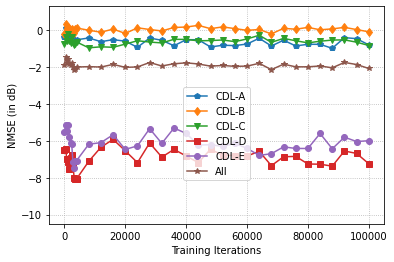

In [351]:
#model_vec = np.concatenate([np.arange(0,4400,freq_1),np.arange(8000,101000,freq_2)])
plt.plot(model_vec,10*np.log10(nmse_ABCDE_CWGAN_snr_20_ld_65_noGP_v2[0,:]),'p-',label='CDL-A')
plt.plot(model_vec,10*np.log10(nmse_ABCDE_CWGAN_snr_20_ld_65_noGP_v2[1,:]),'d-',label='CDL-B')
plt.plot(model_vec,10*np.log10(nmse_ABCDE_CWGAN_snr_20_ld_65_noGP_v2[2,:]),'v-',label='CDL-C')
plt.plot(model_vec,10*np.log10(nmse_ABCDE_CWGAN_snr_20_ld_65_noGP_v2[3,:]),'s-',label='CDL-D')
plt.plot(model_vec,10*np.log10(nmse_ABCDE_CWGAN_snr_20_ld_65_noGP_v2[4,:]),'o-',label='CDL-E')
plt.plot(model_vec,10*np.log10(np.mean(nmse_by_channel_CWGAN_snr_20_ld_65_noGP_v2,axis=2)).T[:,0],'*-',label='All')
plt.legend(loc = (0.4,0.2))
plt.xlabel('Training Iterations')
plt.ylabel('NMSE (in dB)')
plt.ylim([-10.5,1.3])
plt.grid(ls=':')
#plt.savefig('results/CWGAN_no_GP_NMSE_Training_Iterations_LD_65_reset_optim_D.pdf',dpi=5000)

In [345]:
(10*np.log10(np.mean(nmse_by_channel_CWGAN_snr_20_ld_65_noGP_v2,axis=2)).T[:,0])

array([-1.86884201, -1.44697784, -1.7566064 , -1.55355057, -1.80754952,
       -1.90448203, -1.78834809, -2.0138651 , -2.16327476, -2.0789428 ,
       -1.99315843, -1.9708039 , -1.99333632, -1.8506887 , -2.00918581,
       -1.98805101, -1.74774278, -1.93571659, -1.81449775, -1.76601482,
       -1.82629852, -1.94413592, -1.90796685, -1.95525781, -1.94244754,
       -1.79128941, -2.13467006, -1.83806762, -1.98162921, -1.98047191,
       -1.93558645, -2.03450932, -1.74344087, -1.85630266, -2.07086766])

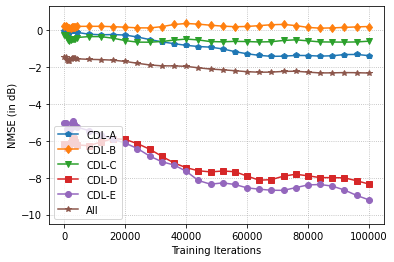

In [244]:
#model_vec = np.arange(52000,101000,freq_2)
nmse_ABCDE_CWGAN_snr_30_ld_65_noGP = np.zeros((5,len(model_vec)))
nmse_ABCDE_CWGAN_snr_30_ld_65_noGP[0,:] = np.mean(nmse_by_channel_CWGAN_snr_30_ld_65_noGP[0,:,0:11],axis=1)
nmse_ABCDE_CWGAN_snr_30_ld_65_noGP[1,:] = np.mean(nmse_by_channel_CWGAN_snr_30_ld_65_noGP[0,:,11:21],axis=1)
nmse_ABCDE_CWGAN_snr_30_ld_65_noGP[2,:] = np.mean(nmse_by_channel_CWGAN_snr_30_ld_65_noGP[0,:,21:31],axis=1)
nmse_ABCDE_CWGAN_snr_30_ld_65_noGP[3,:] = np.mean(nmse_by_channel_CWGAN_snr_30_ld_65_noGP[0,:,31:41],axis=1)
nmse_ABCDE_CWGAN_snr_30_ld_65_noGP[4,:] = np.mean(nmse_by_channel_CWGAN_snr_30_ld_65_noGP[0,:,41:],axis=1)
#model_vec = np.concatenate([np.arange(0,4400,freq_1),np.arange(8000,101000,freq_2)])
plt.plot(model_vec,smooth(10*np.log10(nmse_ABCDE_CWGAN_snr_30_ld_65_noGP[0,:]),6),'p-',label='CDL-A')
plt.plot(model_vec,smooth(10*np.log10(nmse_ABCDE_CWGAN_snr_30_ld_65_noGP[1,:]),6),'d-',label='CDL-B')
plt.plot(model_vec,smooth(10*np.log10(nmse_ABCDE_CWGAN_snr_30_ld_65_noGP[2,:]),6),'v-',label='CDL-C')
plt.plot(model_vec,smooth(10*np.log10(nmse_ABCDE_CWGAN_snr_30_ld_65_noGP[3,:]),6),'s-',label='CDL-D')
plt.plot(model_vec,smooth(10*np.log10(nmse_ABCDE_CWGAN_snr_30_ld_65_noGP[4,:]),6),'o-',label='CDL-E')
plt.plot(model_vec,smooth(10*np.log10(np.mean(nmse_by_channel_CWGAN_snr_30_ld_65_noGP,axis=2)).T[:,0],6),'*-',label='All')
plt.legend(loc='lower left')
plt.xlabel('Training Iterations')
plt.ylabel('NMSE (in dB)')
plt.ylim([-10.5,1.3])
plt.grid(ls=':')
plt.savefig('results/NMSE Training Iterations 30 dB LD 65 no GP.pdf',dpi=5000)

In [271]:
np.savez('results/nmse_snr_training_iter_20_30_pcwgan.npz',nmse_SNR_ABCDE_CWGAN_snr_20_ld_65_noGP,nmse_SNR_ABCDE_CWGAN_snr_30_ld_65_noGP,nmse_ABCDE_CWGAN_snr_20_ld_65_noGP,nmse_ABCDE_CWGAN_snr_30_ld_65_noGP)

In [273]:
#model_vec = range(8000,44000,4000)
nmse_SNR_ABCDE_CWGAN_snr_30_ld_65_noGP = np.zeros((5,len(SNR_vec)))
nmse_SNR_ABCDE_CWGAN_snr_30_ld_65_noGP[0,:] = np.mean(nmse_SNR_by_channel_CWGAN_snr_30_ld_65_noGP[:,0,0:11],axis=1)
nmse_SNR_ABCDE_CWGAN_snr_30_ld_65_noGP[1,:] = np.mean(nmse_SNR_by_channel_CWGAN_snr_30_ld_65_noGP[:,0,11:21],axis=1)
nmse_SNR_ABCDE_CWGAN_snr_30_ld_65_noGP[2,:] = np.mean(nmse_SNR_by_channel_CWGAN_snr_30_ld_65_noGP[:,0,21:31],axis=1)
nmse_SNR_ABCDE_CWGAN_snr_30_ld_65_noGP[3,:] = np.mean(nmse_SNR_by_channel_CWGAN_snr_30_ld_65_noGP[:,0,31:41],axis=1)
nmse_SNR_ABCDE_CWGAN_snr_30_ld_65_noGP[4,:] = np.mean(nmse_SNR_by_channel_CWGAN_snr_30_ld_65_noGP[:,0,41:],axis=1)

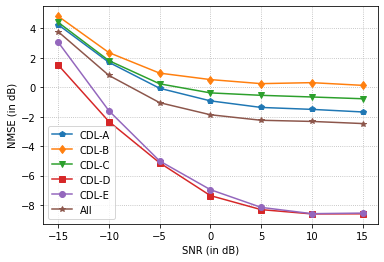

In [359]:
SNR_vec = range(-15,20,5)
plt.plot(SNR_vec,10*np.log10(nmse_SNR_ABCDE_CWGAN_snr_30_ld_65_noGP_v2[0,:]),'p-',label='CDL-A')
plt.plot(SNR_vec,10*np.log10(nmse_SNR_ABCDE_CWGAN_snr_30_ld_65_noGP_v2[1,:]),'d-',label='CDL-B')
plt.plot(SNR_vec,10*np.log10(nmse_SNR_ABCDE_CWGAN_snr_30_ld_65_noGP_v2[2,:]),'v-',label='CDL-C')
plt.plot(SNR_vec,10*np.log10(nmse_SNR_ABCDE_CWGAN_snr_30_ld_65_noGP_v2[3,:]),'s-',label='CDL-D')
plt.plot(SNR_vec,10*np.log10(nmse_SNR_ABCDE_CWGAN_snr_30_ld_65_noGP_v2[4,:]),'o-',label='CDL-E')
plt.plot(SNR_vec,10*np.log10(np.mean(nmse_SNR_by_channel_CWGAN_snr_30_ld_65_noGP_v2,axis=2)),'*-',label='All')
plt.legend(loc='lower left')
plt.xlabel('SNR (in dB)')
plt.ylabel('NMSE (in dB)')
plt.grid(ls=':')

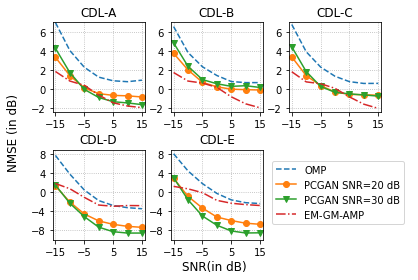

In [409]:
nmse_ABCDE_omp = np.load('../Final/results/nmse_omp_by_channel.npy')
nmse_ABCDE_emgmamp = sio.loadmat('../Final/results/NMSE_EMGMAMP_3.mat')['nmse_emgmamp_3']
fig = plt.figure()
ax1 = plt.subplot2grid(shape=(7,54), loc=(0,0), colspan=15, rowspan=3)
ax2 = plt.subplot2grid((7,54), (0,19), colspan=15, rowspan=3)
ax3 = plt.subplot2grid((7,54), (0,38), colspan=15, rowspan=3)
ax4 = plt.subplot2grid((7,54), (4,0), colspan=15, rowspan=3)
ax5 = plt.subplot2grid((7,54), (4,19), colspan=15, rowspan=3)

ax1.plot(SNR_vec,10*np.log10(nmse_ABCDE_omp[0,:]),'--',label='OMP',color='#1f77b4')
ax1.plot(SNR_vec,10*np.log10(nmse_SNR_ABCDE_CWGAN_snr_20_ld_65_noGP_v2[0,:]),'o-',label='PCGAN SNR=20 dB',color='#ff7f0e')
ax1.plot(SNR_vec,10*np.log10(nmse_SNR_ABCDE_CWGAN_snr_30_ld_65_noGP_v2[0,:]),'v-',label='PCGAN SNR=30 dB',color='#2ca02c')
ax1.plot(SNR_vec,nmse_ABCDE_emgmamp[0,:],'-.',label='EM-GM-AMP',color='#d62728')
ax1.grid(ls=':')
ax1.set_xlim([-16,16]); ax1.set_ylim([-2.5,7]); ax1.set_xticks((-15,-5,5,15)); ax1.set_yticks([-2,0,2,4,6])

ax2.plot(SNR_vec,10*np.log10(nmse_ABCDE_omp[1,:]),'--',label='OMP',color='#1f77b4')
ax2.plot(SNR_vec,10*np.log10(nmse_SNR_ABCDE_CWGAN_snr_20_ld_65_noGP_v2[1,:]),'o-',label='PCGAN SNR=20 dB',color='#ff7f0e')
ax2.plot(SNR_vec,10*np.log10(nmse_SNR_ABCDE_CWGAN_snr_30_ld_65_noGP_v2[1,:]),'v-',label='PCGAN SNR=30 dB',color='#2ca02c')
ax2.plot(SNR_vec,nmse_ABCDE_emgmamp[1,:],'-.',label='EM-GM-AMP',color='#d62728')
ax2.grid(ls=':')
ax2.set_xlim([-16,16]); ax2.set_ylim([-2.5,7]); ax2.set_xticks((-15,-5,5,15)); ax2.set_yticks([-2,0,2,4,6])

ax3.plot(SNR_vec,10*np.log10(nmse_ABCDE_omp[2,:]),'--',label='OMP',color='#1f77b4')
ax3.plot(SNR_vec,10*np.log10(nmse_SNR_ABCDE_CWGAN_snr_20_ld_65_noGP_v2[2,:]),'o-',label='PCGAN SNR=20 dB',color='#ff7f0e')
ax3.plot(SNR_vec,10*np.log10(nmse_SNR_ABCDE_CWGAN_snr_30_ld_65_noGP_v2[2,:]),'v-',label='PCGAN SNR=30 dB',color='#2ca02c')
ax3.plot(SNR_vec,nmse_ABCDE_emgmamp[2,:],'-.',label='EM-GM-AMP',color='#d62728')
ax3.grid(ls=':')
ax3.set_xlim([-16,16]); ax3.set_ylim([-2.5,7]); ax3.set_xticks((-15,-5,5,15)); ax3.set_yticks([-2,0,2,4,6])

ax4.plot(SNR_vec,10*np.log10(nmse_ABCDE_omp[3,:]),'--',label='OMP',color='#1f77b4')
ax4.plot(SNR_vec,10*np.log10(nmse_SNR_ABCDE_CWGAN_snr_20_ld_65_noGP_v2[3,:]),'o-',label='PCGAN SNR=20 dB',color='#ff7f0e')
ax4.plot(SNR_vec,10*np.log10(nmse_SNR_ABCDE_CWGAN_snr_30_ld_65_noGP_v2[3,:]),'v-',label='PCGAN SNR=30 dB',color='#2ca02c')
ax4.plot(SNR_vec,nmse_ABCDE_emgmamp[3,:],'-.',label='EM-GM-AMP',color='#d62728')
ax4.grid(ls=':')
ax4.set_xlim([-16,16]); ax4.set_ylim([-10,9]); ax4.set_xticks((-15,-5,5,15)); ax4.set_yticks([-8,-4,0,4,8])

ax5.plot(SNR_vec,10*np.log10(nmse_ABCDE_omp[4,:]),'--',label='OMP',color='#1f77b4')
ax5.plot(SNR_vec,10*np.log10(nmse_SNR_ABCDE_CWGAN_snr_20_ld_65_noGP_v2[4,:]),'o-',label='PCGAN SNR=20 dB',color='#ff7f0e')
ax5.plot(SNR_vec,10*np.log10(nmse_SNR_ABCDE_CWGAN_snr_30_ld_65_noGP_v2[4,:]),'v-',label='PCGAN SNR=30 dB',color='#2ca02c')
ax5.plot(SNR_vec,nmse_ABCDE_emgmamp[4,:],'-.',label='EM-GM-AMP',color='#d62728')
ax5.grid(ls=':')
ax5.set_xlim([-16,16]); ax5.set_ylim([-10,9]); ax5.set_xticks((-15,-5,5,15)); ax5.set_yticks([-8,-4,0,4,8])

ax1.title.set_text('CDL-A')
ax2.title.set_text('CDL-B')
ax3.title.set_text('CDL-C')
ax4.title.set_text('CDL-D')
ax5.title.set_text('CDL-E')

fig.supylabel('NMSE (in dB)')
fig.supxlabel('SNR(in dB)')

handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc=(0.65,0.2))
plt.savefig('../Final/results/PCGAN_NMSE_SNR.pdf',dpi=50000)

In [417]:
print(10*np.log10(nmse_SNR_ABCDE_CWGAN_snr_30_ld_65_noGP_v2[2,:]))
print(10*np.log10(nmse_SNR_ABCDE_CWGAN_noGP_ld_65[2,:]))

[ 4.40869742  1.8073805   0.23200659 -0.38421418 -0.54879138 -0.66189118
 -0.78255309]
[ 3.86291798  1.72914675  0.31372503 -0.57296962 -0.70253167 -0.90949909
 -0.82587105]


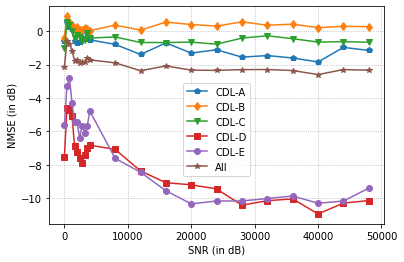

In [202]:
plt.plot(model_vec,10*np.log10(nmse_ABCDE_CWGAN_noGP_ld_65_v2[0,:]),'p-',label='CDL-A')
plt.plot(model_vec,10*np.log10(nmse_ABCDE_CWGAN_noGP_ld_65_v2[1,:]),'d-',label='CDL-B')
plt.plot(model_vec,10*np.log10(nmse_ABCDE_CWGAN_noGP_ld_65_v2[2,:]),'v-',label='CDL-C')
plt.plot(model_vec,10*np.log10(nmse_ABCDE_CWGAN_noGP_ld_65_v2[3,:]),'s-',label='CDL-D')
plt.plot(model_vec,10*np.log10(nmse_ABCDE_CWGAN_noGP_ld_65_v2[4,:]),'o-',label='CDL-E')
plt.plot(model_vec,10*np.log10(np.mean(nmse_by_channel_CWGAN_noGP_ld_65_v2,axis=2)).T,'*-',label='All')
plt.legend(loc=(0.4,0.22))
plt.xlabel('SNR (in dB)')
plt.ylabel('NMSE (in dB)')
plt.grid(ls=':')

In [251]:
model_vec = np.concatenate([np.arange(0,4400,freq_1),np.arange(8000,101000,freq_2)])
model_vec[np.argmin(10*np.log10(np.mean(nmse_by_channel_CWGAN_snr_20_ld_65_noGP,axis=2)))]

48000

(-10.5, 1.3)

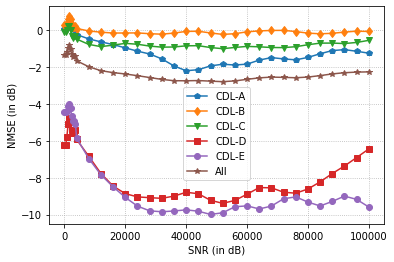

In [160]:
model_vec = np.concatenate([np.arange(0,4400,freq_1),np.arange(8000,101000,freq_2)])
plt.plot(model_vec,smooth(10*np.log10(np.concatenate([nmse_ABCDE_CWGAN_snr_30_ld_65[0,:],nmse_ABCDE_CWGAN_snr_30_ld_65_2[0,:]])),6),'p-',label='CDL-A')
plt.plot(model_vec,smooth(10*np.log10(np.concatenate([nmse_ABCDE_CWGAN_snr_30_ld_65[1,:],nmse_ABCDE_CWGAN_snr_30_ld_65_2[1,:]])),6),'d-',label='CDL-B')
plt.plot(model_vec,smooth(10*np.log10(np.concatenate([nmse_ABCDE_CWGAN_snr_30_ld_65[2,:],nmse_ABCDE_CWGAN_snr_30_ld_65_2[2,:]])),6),'v-',label='CDL-C')
plt.plot(model_vec,smooth(10*np.log10(np.concatenate([nmse_ABCDE_CWGAN_snr_30_ld_65[3,:],nmse_ABCDE_CWGAN_snr_30_ld_65_2[3,:]])),6),'s-',label='CDL-D')
plt.plot(model_vec,smooth(10*np.log10(np.concatenate([nmse_ABCDE_CWGAN_snr_30_ld_65[4,:],nmse_ABCDE_CWGAN_snr_30_ld_65_2[4,:]])),6),'o-',label='CDL-E')
plt.plot(model_vec,smooth(10*np.log10(np.concatenate([np.mean(nmse_by_channel_CWGAN_snr_30_ld_65,axis=2),np.mean(nmse_by_channel_CWGAN_snr_30_ld_65_2,axis=2)],axis=1)).T[:,0],6),'*-',label='All')
plt.legend(loc=(0.4,0.2))
plt.xlabel('SNR (in dB)')
plt.ylabel('NMSE (in dB)')
plt.grid(ls=':')
plt.ylim([-10.5,1.3])
plt.savefig('results/NMSE Training Iterations 30 dB LD 65.pdf',dpi=10000)

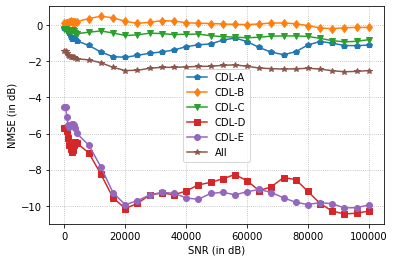

In [186]:
model_vec = np.concatenate([np.arange(0,4400,freq_1),np.arange(8000,101000,freq_2)])
plt.plot(model_vec,smooth(10*np.log10(np.concatenate([nmse_ABCDE_CWGAN_noGP_ld_65[0,:],nmse_ABCDE_CWGAN_noGP_ld_65_2[0,:]])),6),'p-',label='CDL-A')
plt.plot(model_vec,smooth(10*np.log10(np.concatenate([nmse_ABCDE_CWGAN_noGP_ld_65[1,:],nmse_ABCDE_CWGAN_noGP_ld_65_2[1,:]])),6),'d-',label='CDL-B')
plt.plot(model_vec,smooth(10*np.log10(np.concatenate([nmse_ABCDE_CWGAN_noGP_ld_65[2,:],nmse_ABCDE_CWGAN_noGP_ld_65_2[2,:]])),6),'v-',label='CDL-C')
plt.plot(model_vec,smooth(10*np.log10(np.concatenate([nmse_ABCDE_CWGAN_noGP_ld_65[3,:],nmse_ABCDE_CWGAN_noGP_ld_65_2[3,:]])),6),'s-',label='CDL-D')
plt.plot(model_vec,smooth(10*np.log10(np.concatenate([nmse_ABCDE_CWGAN_noGP_ld_65[4,:],nmse_ABCDE_CWGAN_noGP_ld_65_2[4,:]])),6),'o-',label='CDL-E')
plt.plot(model_vec,smooth(10*np.log10(np.concatenate([np.mean(nmse_by_channel_CWGAN_noGP_ld_65,axis=2),np.mean(nmse_by_channel_CWGAN_noGP_ld_65_2,axis=2)],axis=1)).T[:,0],6),'*-',label='All')
plt.legend()
plt.xlabel('SNR (in dB)')
plt.ylabel('NMSE (in dB)')
plt.grid(ls=':')
plt.savefig('results/CWGAN_no_GP_NMSE_Training_Iterations_LD_65.pdf',dpi=5000)

In [189]:
model_vec[np.argmin(np.concatenate([np.mean(nmse_by_channel_CWGAN_noGP_ld_65,axis=2),np.mean(nmse_by_channel_CWGAN_noGP_ld_65_2,axis=2)],axis=1))]

96000

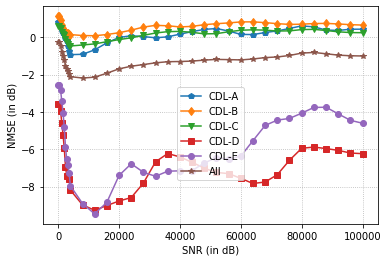

In [152]:
model_vec = np.concatenate([np.arange(0,4400,freq_1),np.arange(8000,101000,freq_2)])
plt.plot(model_vec,smooth(10*np.log10(np.concatenate([nmse_ABCDE_CWGAN_ld_65_e20[0,:],nmse_ABCDE_CWGAN_ld_65_e20_2[0,:]])),6),'p-',label='CDL-A')
plt.plot(model_vec,smooth(10*np.log10(np.concatenate([nmse_ABCDE_CWGAN_ld_65_e20[1,:],nmse_ABCDE_CWGAN_ld_65_e20_2[1,:]])),6),'d-',label='CDL-B')
plt.plot(model_vec,smooth(10*np.log10(np.concatenate([nmse_ABCDE_CWGAN_ld_65_e20[2,:],nmse_ABCDE_CWGAN_ld_65_e20_2[2,:]])),6),'v-',label='CDL-C')
plt.plot(model_vec,smooth(10*np.log10(np.concatenate([nmse_ABCDE_CWGAN_ld_65_e20[3,:],nmse_ABCDE_CWGAN_ld_65_e20_2[3,:]])),6),'s-',label='CDL-D')
plt.plot(model_vec,smooth(10*np.log10(np.concatenate([nmse_ABCDE_CWGAN_ld_65_e20[4,:],nmse_ABCDE_CWGAN_ld_65_e20_2[4,:]])),6),'o-',label='CDL-E')
plt.plot(model_vec,smooth(10*np.log10(np.concatenate([np.mean(nmse_by_channel_CWGAN_ld_65_e20,axis=2),np.mean(nmse_by_channel_CWGAN_ld_65_e20_2,axis=2)],axis=1)).T[:,0],6),'*-',label='All')
plt.legend(loc=(0.4,0.2))
plt.xlabel('SNR (in dB)')
plt.ylabel('NMSE (in dB)')
plt.grid(ls=':')

In [132]:
print(model_vec[np.argmin(10*np.log10(np.mean(nmse_by_channel_CWGAN_snr_20_ld_65,axis=2)))])
print(model_vec[np.argmin(10*np.log10(np.concatenate([np.mean(nmse_by_channel_CWGAN_snr_30_ld_65,axis=2),np.mean(nmse_by_channel_CWGAN_snr_30_ld_65_2,axis=2)],axis=1)).T)])

36000
36000


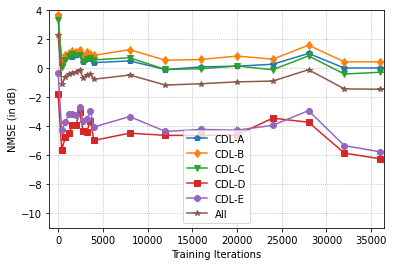

In [67]:
model_vec = np.concatenate([np.arange(0,4400,400),np.arange(8000,44000,4000)])

#GCE
plt.plot(model_vec,10*np.log10(np.concatenate([nmse_ABCDE_snr_20[0,:],nmse_ABCDE_snr_20_2[0,:]])),'p-',label='CDL-A')
plt.plot(model_vec,10*np.log10(np.concatenate([nmse_ABCDE_snr_20[1,:],nmse_ABCDE_snr_20_2[1,:]])),'d-',label='CDL-B')
plt.plot(model_vec,10*np.log10(np.concatenate([nmse_ABCDE_snr_20[2,:],nmse_ABCDE_snr_20_2[2,:]])),'v-',label='CDL-C')
plt.plot(model_vec,10*np.log10(np.concatenate([nmse_ABCDE_snr_20[3,:],nmse_ABCDE_snr_20_2[3,:]])),'s-',label='CDL-D')
plt.plot(model_vec,10*np.log10(np.concatenate([nmse_ABCDE_snr_20[4,:],nmse_ABCDE_snr_20_2[4,:]])),'o-',label='CDL-E')
plt.plot(model_vec,10*np.log10(np.concatenate([np.mean(nmse_by_channel_snr_20,axis=2),np.mean(nmse_by_channel_snr_20_2,axis=2)],axis=1)).T,'*-',label='All')
plt.legend(loc='lower center')
plt.xlabel('Training Iterations')
plt.ylabel('NMSE (in dB)')
plt.grid(ls=':')
plt.xlim([-1000,36440])
plt.ylim([-11,4])

#OMP
plt.axhline(y=0.8954940524095136, color='#1f77b4', linestyle='dashdot')
plt.axhline(y=0.6394309088492918, color='#ff7f0e', linestyle='dashdot')
plt.axhline(y=0.5595108583571069, color='#2ca02c', linestyle='dashdot')
plt.axhline(y=-3.4785192704574017, color='#d62728', linestyle='dashdot')
plt.axhline(y=-2.3821076957188887, color='#9467bd', linestyle='dashdot')

plt.savefig('results/NMSE Training Iterations 20 dB.pdf',dpi=1000)

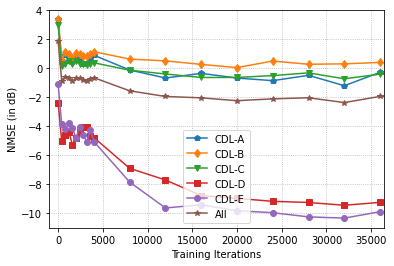

In [66]:
model_vec = np.concatenate([np.arange(0,4400,400),np.arange(8000,44000,4000)])

#GCE
plt.plot(model_vec,10*np.log10(np.concatenate([nmse_ABCDE[0,:],nmse_ABCDE_2[0,:],nmse_ABCDE_3[0,:]])),'p-',label='CDL-A')
plt.plot(model_vec,10*np.log10(np.concatenate([nmse_ABCDE[1,:],nmse_ABCDE_2[1,:],nmse_ABCDE_3[1,:]])),'d-',label='CDL-B')
plt.plot(model_vec,10*np.log10(np.concatenate([nmse_ABCDE[2,:],nmse_ABCDE_2[2,:],nmse_ABCDE_3[2,:]])),'v-',label='CDL-C')
plt.plot(model_vec[:-1],10*np.log10(np.concatenate([nmse_ABCDE[3,:],nmse_ABCDE_2[3,:],nmse_ABCDE_3[3,:]]))[:-1],'s-',label='CDL-D')
plt.plot(model_vec,10*np.log10(np.concatenate([nmse_ABCDE[4,:],nmse_ABCDE_2[4,:],nmse_ABCDE_3[4,:]])),'o-',label='CDL-E')
plt.plot(model_vec,10*np.log10(np.concatenate([np.mean(nmse_by_channel,axis=2),np.mean(nmse_by_channel_2,axis=2),np.mean(nmse_by_channel_3,axis=2)],axis=1)).T,'*-',label='All')
plt.legend(loc='lower center')
plt.xlabel('Training Iterations')
plt.ylabel('NMSE (in dB)')
plt.grid(ls=':')

#OMP
plt.axhline(y=0.8954940524095136, color='#1f77b4', linestyle='dashdot')
plt.axhline(y=0.6394309088492918, color='#ff7f0e', linestyle='dashdot')
plt.axhline(y=0.5595108583571069, color='#2ca02c', linestyle='dashdot')
plt.axhline(y=-3.4785192704574017, color='#d62728', linestyle='dashdot')
plt.axhline(y=-2.3821076957188887, color='#9467bd', linestyle='dashdot')

plt.xlim([-1000,36440])
plt.ylim([-11,4])

plt.savefig('results/NMSE Training Iterations 30 dB.pdf',dpi=1000)

In [74]:
(np.concatenate([np.mean(nmse_by_channel,axis=2),np.mean(nmse_by_channel_2,axis=2),np.mean(nmse_by_channel_3,axis=2)],axis=1))

array([[1.55540736, 0.81415453, 0.87312882, 0.86456124, 0.81522756,
        0.85304045, 0.85149184, 0.8265534 , 0.82003739, 0.84690706,
        0.86195322, 0.69981681, 0.63978802, 0.62587905, 0.59834141,
        0.61583255, 0.62651143, 0.58079683, 0.64017814, 0.61527561]])

In [51]:
SNR_vec = range(-15,20,5)
nmse_ls = np.zeros((len(SNR_vec),ntest))
ct = 0
for SNR in SNR_vec:
    ct += 1
    for i in range(nrepeat):
        pilot_sequence_ind = np.random.randint(0,4,size=(N_s,N_p))
        symbols = qpsk_constellation[pilot_sequence_ind]
        precoder_training = training_precoder(N_t,N_s)
        W = training_combiner(N_r,N_rx_rf)
        tx = np.transpose(np.matmul(precoder_training,symbols))
        A = np.kron(np.matmul(symbols.T,precoder_training.T),W)
        A_mat = np.matmul(np.linalg.pinv(np.kron(tx,W)),np.kron(eye_N_p,W))
        A1 = np.kron(tx,W)
        A2 = np.linalg.pinv(A1)
        for ind in range(0,H_ex.shape[2],5):
            vec_H_single = np.reshape(H_ex[:,:,ind].flatten('F'),[N_r*N_t,1])
            signal = np.matmul(H_ex[:,:,ind],np.matmul(precoder_training,symbols))
            E_s = np.multiply(signal,np.conj(signal))
            noise_matrix = (1/np.sqrt(2))*(np.random.randn(N_r,N_p)+1j*np.random.randn(N_r,N_p))
            vec_y = np.zeros((N_r*N_t,1,1),dtype='complex64')
            std_dev = (1/(10**(SNR/20)))*np.sqrt(E_s)
            ls_signal = np.matmul(A2,np.matmul(A1,vec_H_single))
            rx_signal = np.matmul(A_R_T,ls_signal + np.matmul(A_mat,np.reshape(np.multiply(std_dev,noise_matrix).flatten('F'),[N_r*N_p,1])))
            nmse_ls[ct-1,int(ind/5)] = nmse_ls[ct-1,int(ind/5)] + (np.linalg.norm(rx_signal - np.matmul(A_R_T,vec_H_single))/np.linalg.norm(np.matmul(A_R_T,vec_H_single)))**2
            print(ind,10*np.log10((np.linalg.norm(rx_signal - np.matmul(A_R_T,vec_H_single))/np.linalg.norm(np.matmul(A_R_T,vec_H_single)))**2))
nmse_ls = nmse_ls/(nrepeat)

0 13.931961129850745
5 14.7325832352536
10 13.509807635846236
15 13.399706362742696
20 10.011268303456388
25 11.611429747024157
30 12.372022551570305
35 11.940144962305384
40 10.571689143024548
45 13.44027565922862
50 11.408763189840885
55 11.624920598241268
60 12.53373281672297
65 10.773262824487105
70 12.078686762293477
75 13.338623747866208
80 13.328716088137885
85 12.718563461953313
90 12.134651867174785
95 10.518751644027695
100 12.070146213531556
105 12.783642733319232
110 11.439307458804905
115 11.123004278212608
120 12.695288561441263
125 11.844292418446997
130 12.30366624500785
135 12.797198923693342
140 13.644126962762439
145 11.476111450028782
150 12.115562650155315
155 12.78194643168031
160 13.616056301150978
165 12.763904713699661
170 12.053498636764362
175 11.464923803732994
180 12.560244745331914
185 13.497997100630359
190 12.220289765540075
195 12.10512366936082
200 11.852443342016148
205 12.23336198025043
210 11.459987802615313
215 10.58686845109722
220 10.339623720887

In [59]:
nmse_ABCDE_ls = np.zeros((len(SNR_vec),5))
nmse_ABCDE_ls[:,0] = np.mean(nmse_ls[:,0:11],axis=1)
nmse_ABCDE_ls[:,1] = np.mean(nmse_ls[:,11:21],axis=1)
nmse_ABCDE_ls[:,2] = np.mean(nmse_ls[:,21:31],axis=1)
nmse_ABCDE_ls[:,3] = np.mean(nmse_ls[:,31:41],axis=1)
nmse_ABCDE_ls[:,4] = np.mean(nmse_ls[:,41:],axis=1)
np.save('nmse_ls.npy',nmse_ABCDE_ls)

Text(0.5, 1.0, 'CDL-E')

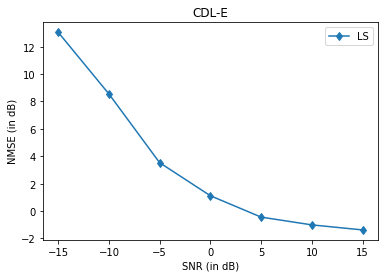

In [58]:
plt.plot(SNR_vec,10*np.log10(nmse_ABCDE_ls[:,4]),'d-',label='LS')
plt.legend()
plt.xlabel('SNR (in dB)')
plt.ylabel('NMSE (in dB)')
plt.title('CDL-E')

In [136]:
def smooth(x,window_len=4,window='hanning'):
    if window_len<3:
        return x

    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y[(int(window_len/2)-1):-int(window_len/2)]